In [2]:
import pandas as pd
from ftplib import FTP
import os

In [3]:
#read in supplementary table
drugInfo = pd.read_csv("Drug_Info_Supp_Table.csv")
drugInfo["Drug"] = drugInfo["Drug"].str.strip()

#group all drugs by their type and turn into dictionary
drugTypes = drugInfo.groupby("Type")["Drug"].apply(list).to_dict()

# get ordered list of drugs arranged by drug type
orderedDrugsList = []
type_boundaries = []
for type, drugs in drugTypes.items():
    for drug in drugs:
        orderedDrugsList.append(drug)
    type_boundaries.append(len(orderedDrugsList))

In [11]:
# make a table with all mean intensity values for all of the drugs
allDrugs = drugInfo["Drug"].to_list()
combined = pd.DataFrame(columns=["gene"])

# set up FTP 
ftp = FTP("massive-ftp.ucsd.edu")
ftp.login()
ftp.cwd("/v06/MSV000093659/other/Dose response data - Jurkat proteome")

for drug in allDrugs:
    # make a string with the drug name + _ALL.txt 
    drugFileName = f"{drug}_ALL.txt"

    # check if the file already exists locally (already downloaded it)
    if not os.path.exists(drugFileName):

        # if it doesn't already exist, use FTP to get that file from the server
        drugPath = f"{drug}/TXTs_Classified"
        ftp.cwd(drugPath)
        
        # download/write the file in binary mode
        with open(drugFileName, "wb") as file:
        # download the file "RETR fileName"
            ftp.retrbinary(f"RETR {drugFileName}", file.write)
        
        # move back to the Jurkat proteome directory
        ftp.cwd("../../")

    # load the file as a dataframe
    drugData = pd.read_csv(drugFileName, delimiter = "\t") 

    # select the gene and mean intensity columns  
    intensityData = drugData[["gene", "Normalized_Intensity_10000"]]
    # rename mean intensity column to include the name of the drug
    renamedData = intensityData.rename(columns = {"Normalized_Intensity_10000":f"{drug}"})
    # add both of those columns to a combined dataframe (Created before the for loop)
    combined = pd.merge(combined, renamedData, how = "outer", on = "gene")

ftp.quit()
combined.set_index("gene")
combined.head()
combined.to_csv("Normalized_Intensity_Matrix_10000_All_Drugs.csv", index = False)


In [ ]:
# create cosine similarity matrix for normalized intensity (10,000)
import numpy
import sklearn 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt


# load matrix and fill in empty vals with 0 
normalizedIntensityMatrix = pd.read_csv("Normalized_Intensity_Matrix_10000_All_Drugs.csv", index_col = 0).fillna(0)
# make column names just the drug name (remove _Mean_Intensity suffix!)
#normalizedIntensityMatrix.columns = normalizedIntensityMatrix.columns.str.removesuffix("_Mean_Intensity")

# transpose data so drugs become rows instead of columns
transposedData = normalizedIntensityMatrix.transpose()
# save drug names index column for after
drugNames = transposedData.index

# plug transposed data into cosine_similarity function
normalizedCosineSimilarityMatrix = cosine_similarity(transposedData)
# convert to a dataframe and make row and column labels be the drug names
normalizedCosineSimilarityMatrix = pd.DataFrame(normalizedCosineSimilarityMatrix, columns = drugNames, index = drugNames)
normalizedCosineSimilarityMatrix.to_csv("Normalized_Cosine_Similarity_Matrix.csv")

reorderedCosMatrix = normalizedCosineSimilarityMatrix.loc[orderedDrugsList, orderedDrugsList]

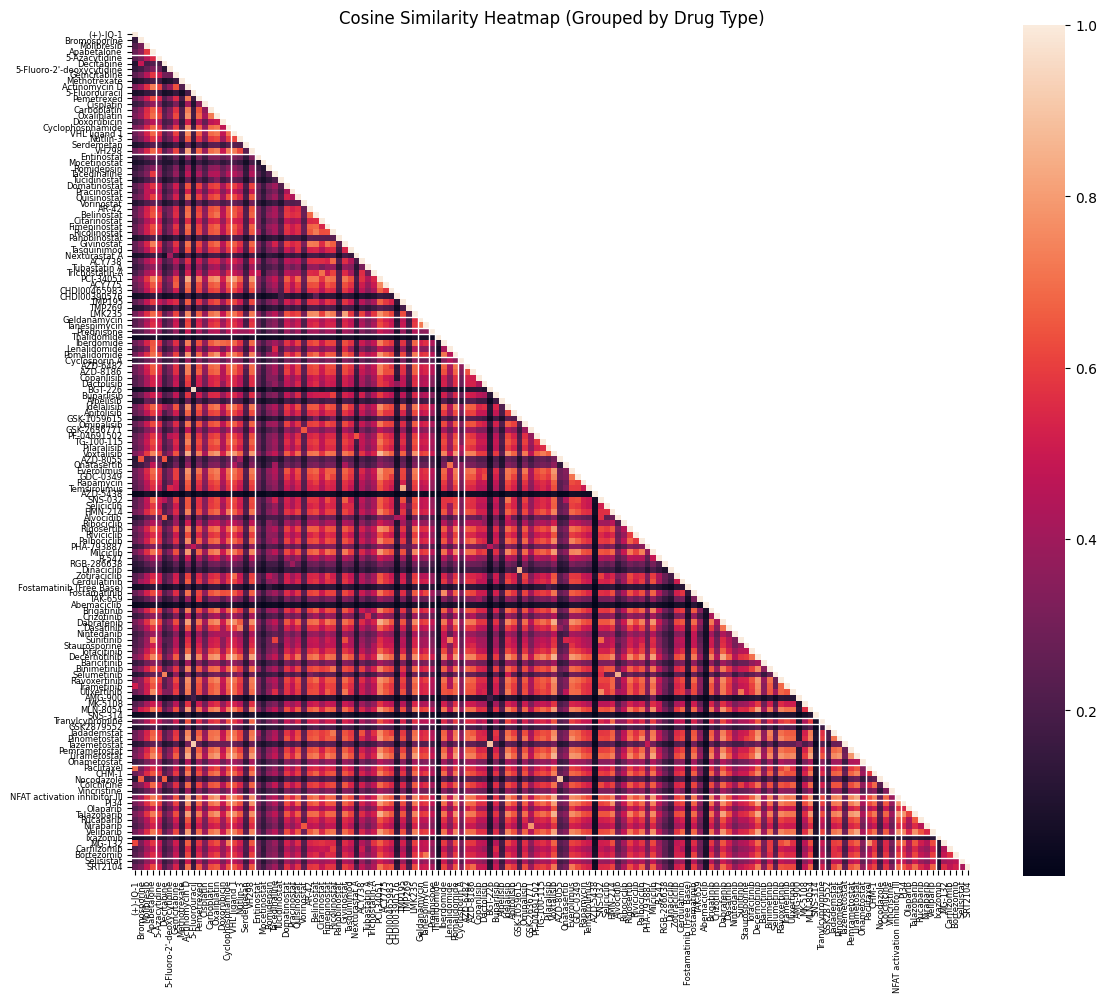

In [24]:
# plot cosine similarity heatmap 
upperMask = numpy.triu(numpy.ones_like(reorderedCosMatrix, dtype=bool), k=1)

# plot heatmap with boundary lines
plt.figure(figsize=(12, 10))
sns.heatmap(reorderedCosMatrix, square=True, xticklabels=True, yticklabels=True, mask = upperMask)
plt.xticks(rotation=90, fontsize = 6)
plt.yticks(rotation=0, fontsize = 6)

# draw grid lines at group boundaries
for boundary in type_boundaries[:-1]:  # skip the last boundary (not needed)
    plt.axhline(boundary, color='white', linewidth=1)
    plt.axvline(boundary, color='white', linewidth=1)

plt.title("Cosine Similarity Heatmap (Grouped by Drug Type)")
plt.tight_layout()
plt.show()

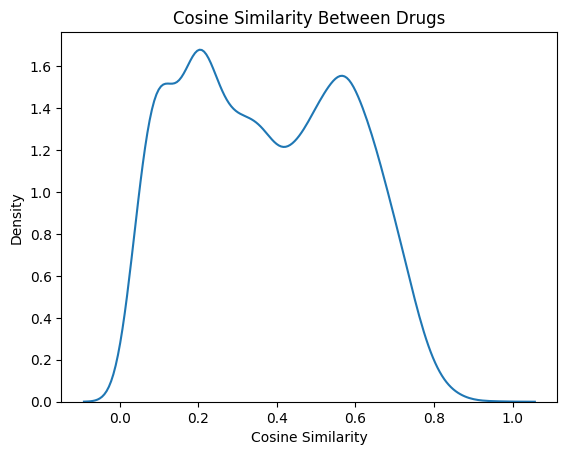

In [21]:
# plot overall cosine distribution for intensity 

cosineArray = normalizedCosineSimilarityMatrix.to_numpy()
# get the indices of the lower triangle in the array
bottomDiagIndices = numpy.tril_indices_from(cosineArray, k = -1)
# use indices to get values of the lower triangle in the array
bottomDiagVals = cosineArray[bottomDiagIndices]

# plot the distribution
sns.kdeplot(bottomDiagVals)
plt.xlabel("Cosine Similarity")
plt.title("Cosine Similarity Between Drugs")
plt.show()

Type: BET inhibitor
Drugs:
	['(+)-JQ-1', 'Bromosporine', 'Molibresib', 'Apabetalone']


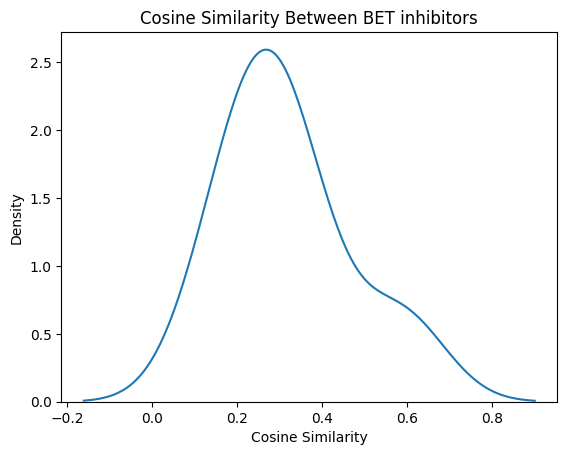

Type: Chemo drug
Drugs:
	['5-Azacytidine', 'Decitabine', "5-Fluoro-2'-deoxycytidine", 'Gemcitabine', 'Methotrexate', 'Actinomycin D', '5-Fluorouracil', 'Pemetrexed', 'Cisplatin', 'Carboplatin', 'Oxaliplatin', 'Doxorubicin', 'Cyclophosphamide']


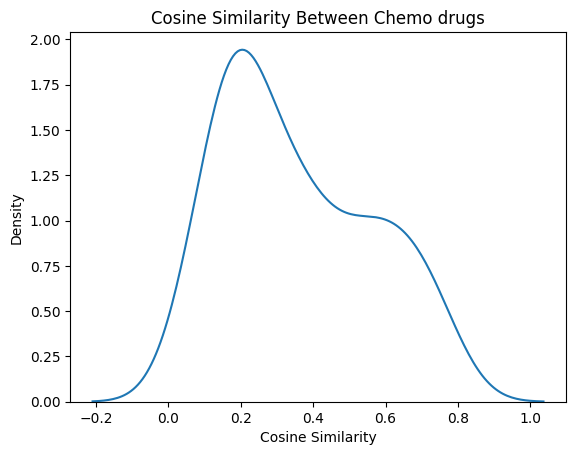

Type: E3 ligase ligands
Drugs:
	['VHL ligand 1', 'Nutlin-3', 'Serdemetan', 'VH298']


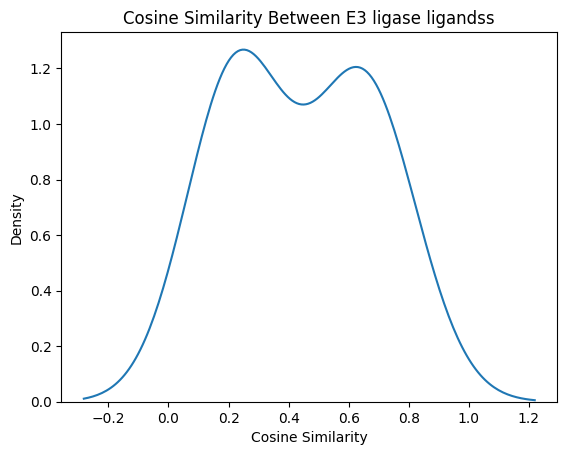

Type: HDAC inhibitor
Drugs:
	['Entinostat', 'Mocetinostat', 'Romidepsin', 'Tacedinaline', 'Tucidinostat', 'Domatinostat', 'Pracinostat', 'Quisinostat', 'Vorinostat', 'AR-42', 'Belinostat', 'Citarinostat', 'Fimepinostat', 'Ricolinostat', 'Panobinostat', 'Givinostat', 'Tasquinimod', 'Nexturastat A', 'ACY738', 'Tubastatin A', 'Trichostatin-A', 'PCI-34051', 'ACY775', 'CHDI00465983', 'CHDI00390576', 'TMP195', 'TMP269', 'LMK235']


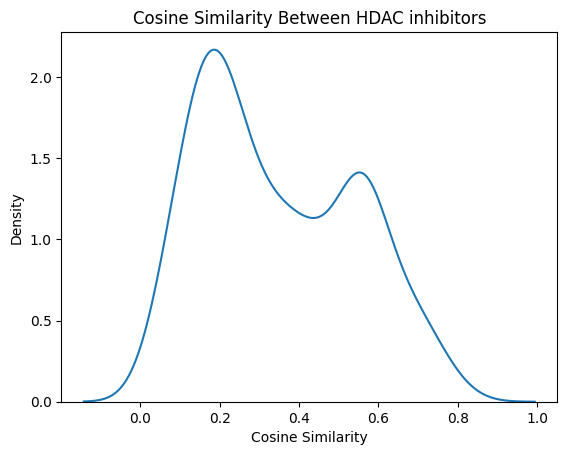

Type: HSP90 inhibitor
Drugs:
	['Geldanamycin', 'Tanespimycin']


/var/folders/25/8s28vb8x6b35yx_pfsfqj06w0000gn/T/ipykernel_87381/4219734345.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subBottomVals)


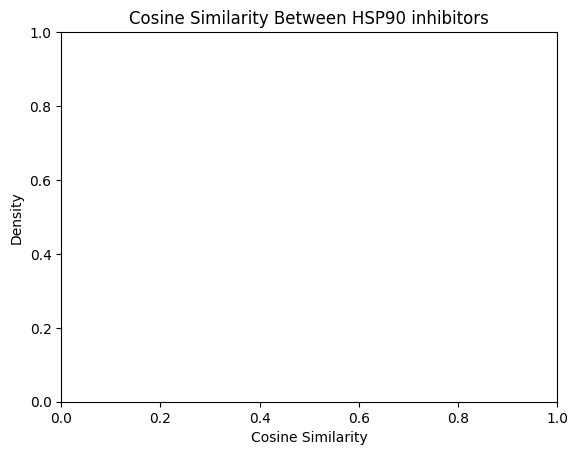

Type: Hormone-like
Drugs:
	['Prednisone']


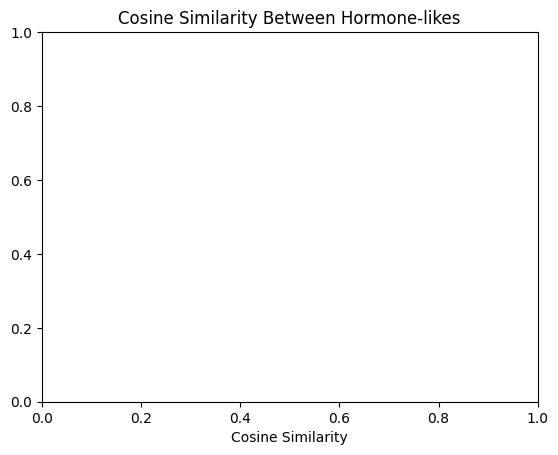

Type: IMiD
Drugs:
	['Thalidomide', 'Iberdomide', 'Lenalidomide', 'Pomalidomide']


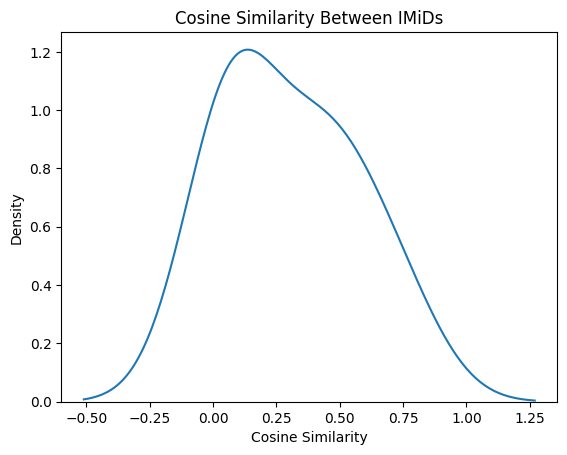

Type: Immunosuppressor
Drugs:
	['Cyclosporin A']


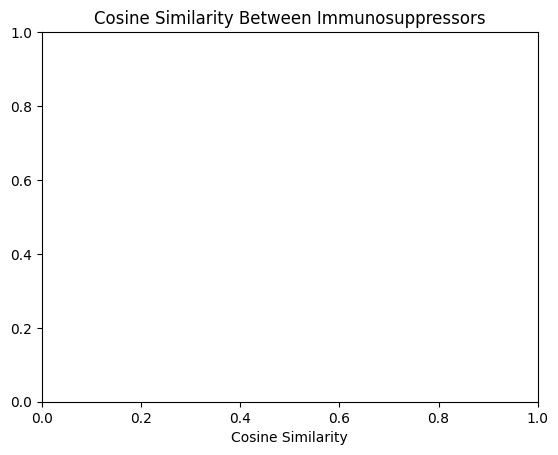

Type: Kinase inhibitor
Drugs:
	['AZD-6482', 'AZD-8186', 'Copanlisib', 'Dactolisib', 'BGT-226', 'Buparlisib', 'Alpelisib', 'Idelalisib', 'Apitolisib', 'GSK-1059615', 'Omipalisib', 'GSK-2636771', 'PF-04691502', 'TG-100-115', 'Pilaralisib', 'Voxtalisib', 'AZD-8055', 'Onatasertib', 'Everolimus', 'GDC-0349', 'Rapamycin', 'Temsirolimus', 'AZD-5438', 'SNS-032', 'Seliciclib', 'HMN-214', 'Alvocidib', 'Ribociclib', 'Rigosertib', 'Riviciclib', 'Palbociclib', 'PHA-793887', 'Milciclib', 'R-547', 'RGB-286638', 'Dinaciclib', 'Zotiraciclib', 'Cerdulatinib', 'Fostamatinib (Free Base)', 'Fostamatinib', 'TAK-659', 'Abemaciclib', 'Brigatinib', 'Crizotinib', 'Dabrafenib', 'Dasatinib', 'Nintedanib', 'Sunitinib', 'Staurosporine', 'Tofacitinib', 'Decernotinib', 'Baricitinib', 'Binimetinib', 'Selumetinib', 'Ravoxertinib', 'Trametinib', 'Ulixertinib', 'AMG-900', 'MK-5108', 'MLN-8054', 'SNS-314']


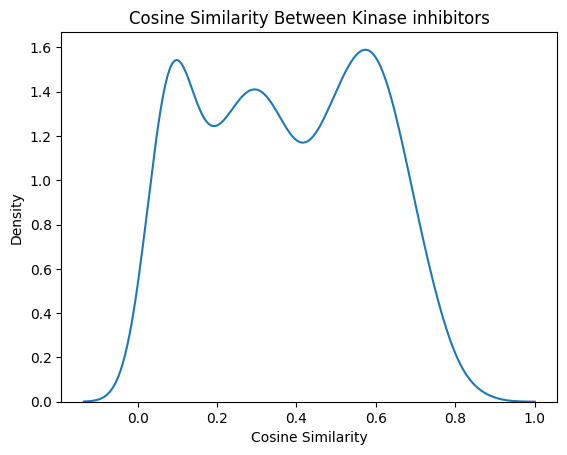

Type: MAOi
Drugs:
	['Tranylcypromine']


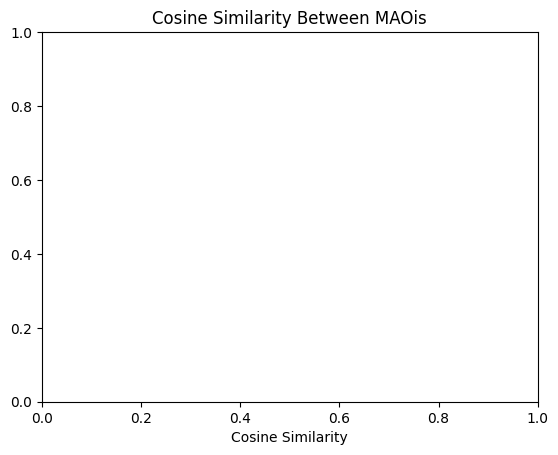

Type: Methyltransferase inhibitor
Drugs:
	['GSK2879552', 'Iadademstat', 'Pinometostat', 'Tazemetostat', 'Pemrametostat', 'Lirametostat', 'Onametostat']


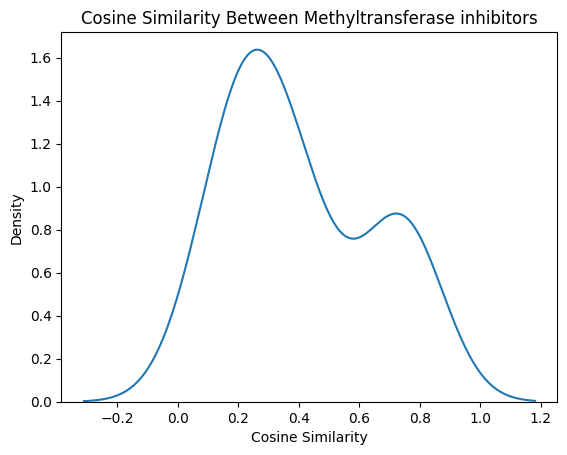

Type: Mitotic inhibitor
Drugs:
	['Paclitaxel', 'CHM-1', 'Nocodazole', 'Colchicine', 'Vincristine']


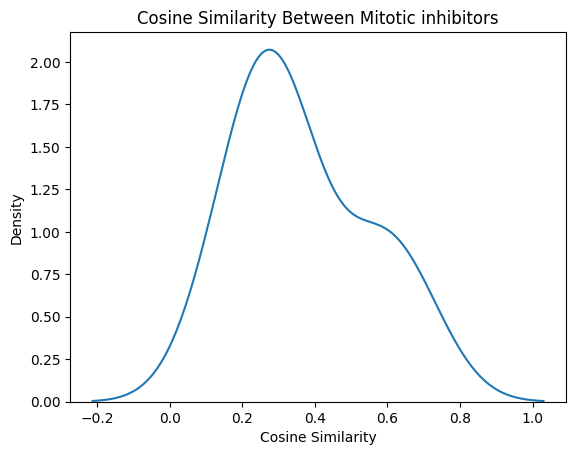

Type: NFAT activation inhibitor
Drugs:
	['NFAT activation inhibitor III']


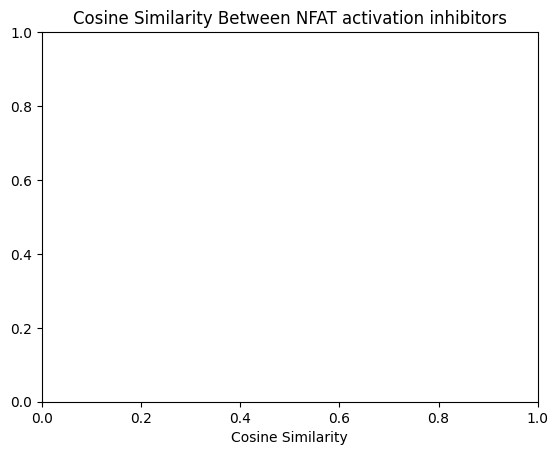

Type: PARP inhibitor
Drugs:
	['PJ34', 'Olaparib', 'Talazoparib', 'Rucaparib', 'Niraparib', 'Veliparib']


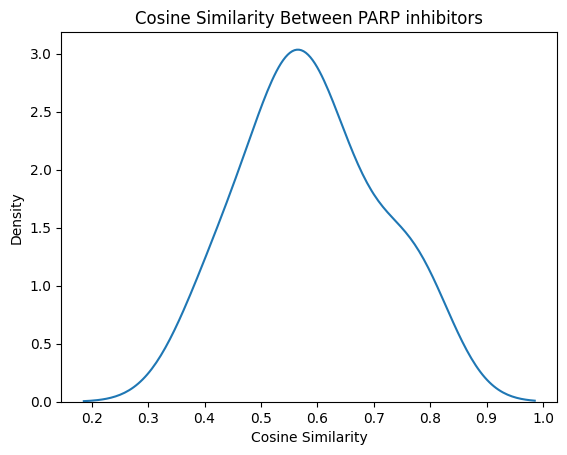

Type: Proteasome inhibitor
Drugs:
	['Ixazomib', 'MG-132', 'Carfilzomib', 'Bortezomib']


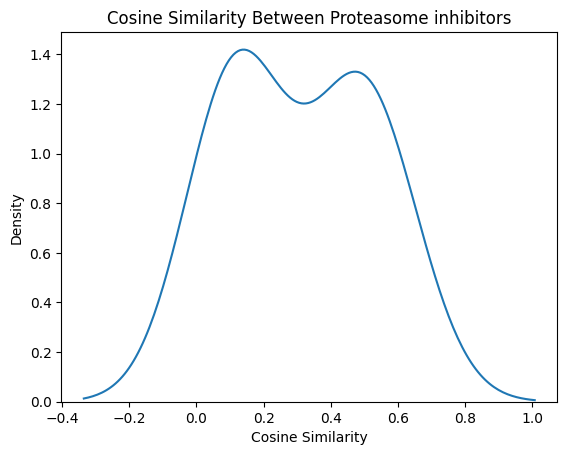

Type: SIRT inhibitor
Drugs:
	['Selisistat', 'SRT2104']


/var/folders/25/8s28vb8x6b35yx_pfsfqj06w0000gn/T/ipykernel_87381/4219734345.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subBottomVals)


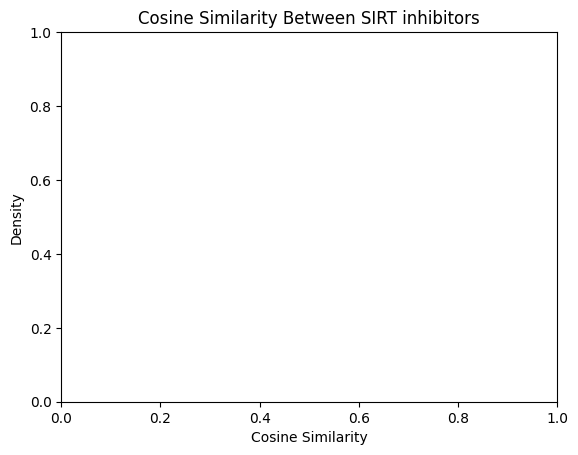

In [22]:
# plot distributions for each drug subtype 
for type, drugNames in drugTypes.items():
    print(f"Type: {type}\nDrugs:\n\t{drugNames}")

    # get the sub-matrix of drugs for this type 
    subTypeMatrix = normalizedCosineSimilarityMatrix.loc[drugNames, drugNames]
    # convert submatrix to a numpy array
    subArray = subTypeMatrix.to_numpy()
    # get indices of the lower triangle
    subBottomIndices = numpy.tril_indices_from(subArray, k = -1)
    # use indices to get values of the lower triangle
    subBottomVals = subArray[subBottomIndices]

    # plot the distribution
    sns.kdeplot(subBottomVals)
    plt.xlabel("Cosine Similarity")
    plt.title(f"Cosine Similarity Between {type}s")
    plt.show()

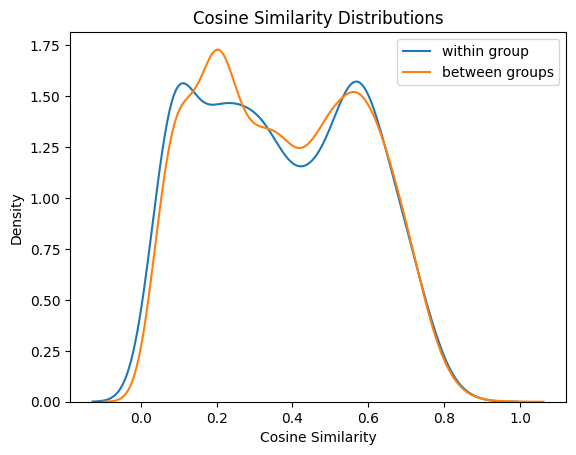

In [23]:
# compare within-group vs between-group similarities

# make one list of all the similarity values for pairs where both drugs are within the same group
withinGroupPairs = []
# make another list of all the similarity values for pairs where the two drugs are in different groups
btwGroupPairs = []
# make new dict with drugs as keys and types as values 
drugsToTypesDict = {}
for type, drugs in drugTypes.items():
    for drug in drugs:
        drugsToTypesDict[drug] = type

# nested for loop
# go through the list of drugs (orderedDrugsList)
for index, drug1 in enumerate(orderedDrugsList):
    # save curr drug (row) type in a var
    drug1Type = drugsToTypesDict[f"{drug1}"]
    # go through the list of drugs again but always starting at i (out loop drug) + 1 
    for drug2Index in range(index+1, len(orderedDrugsList)):
        drug2 = orderedDrugsList[drug2Index]
        # save curr drug (col) type in a var
        drug2Type = drugsToTypesDict[f"{drug2}"]
        # save curr similarity value in a var
        similarity = normalizedCosineSimilarityMatrix.loc[drug1, drug2]
        # if drug 1 type (row) and drug 2 type (col) are the same
        if drug1Type == drug2Type:
            # add value of that pair's comparison (curr loc in the similarity matrix) to withinGroupPairs
            withinGroupPairs.append(similarity)
        else:
            # add value of that pair's comparison (curr loc in the similarity matrix) to btwGroupPairs
            btwGroupPairs.append(similarity)

# plot the distributions of within-group similarities and between-group similarities and compare them
sns.kdeplot(withinGroupPairs, label = "within group")
sns.kdeplot(btwGroupPairs, label = "between groups")
plt.xlabel("Cosine Similarity")
plt.title("Cosine Similarity Distributions")
plt.legend()
plt.show()


# example

# drugs: A B C D E 

# outer loop, drug1 = A, drug1 = B, drug1 = C, drug1 = D, drug1 = E
    # inner loop, drug2 = B, C, D, E. drug2 = C, D, E. drug2 = D, E. drug2 = E. drug2 = done
        # iteration 1 pairs: AB, AC, AD, AE
        # iteration 2 pairs: BC, BD, BE
        # iteration 3 pairs: CD, CE
        # iteration 4 pairs: DE
        # iteration 5 pairs: done
